# Synthetic Dataset Generation

Using the rendering engine provided by `pycamcal.simulation`, generate a synthetic camera calibration dataset for a given camera model.

In [1]:
import numpy as np
import open3d
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R3D

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import pycamcal

## Prepare Camera

In [3]:
from pycamcal.camera_model import CameraModel
from pycamcal.camera_model import RadialTangentialDistortion

distortion = RadialTangentialDistortion(
    k1=-0.25,
    k2=+0.05,
    k3=+0.00,
    p1=+0.01,
    p2=+0.00
)

camera = CameraModel.from_fov(
    res_xy = (1200, 1000),
    fov_xy = (72, 60),
    distortion = distortion
)

print(camera)

if not distortion.is_valid_over_entire_fov(camera.get_fov(degrees=False)):
    print("WARNING: Distortion model is not valid over entire FOV! Certain regions are potentially unreachable and inversion behavior may be undefined.")

precompute_undistort_lut()


<Axes: >

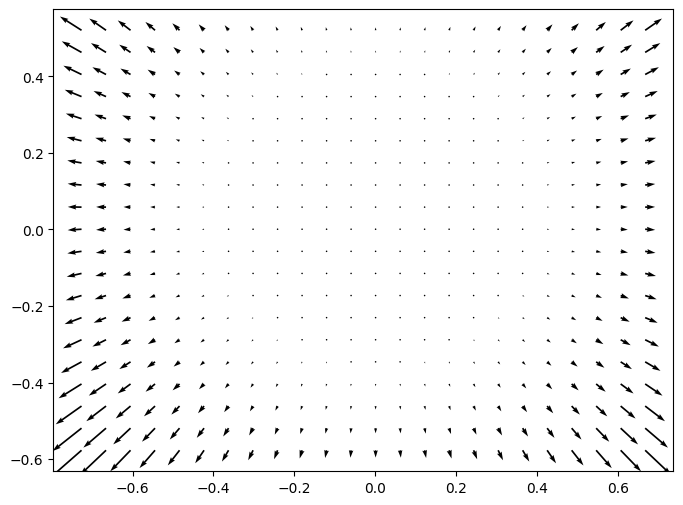

In [4]:
from pycamcal.camera_model.viz_utils import visualize_distortion_model

fig, ax = plt.subplots(figsize=(8, 6))
visualize_distortion_model(camera, subsample=50, exaggeration=0.25, ax=ax)

## Generate Dataset

In [5]:
from pycamcal.simulation.dataset_generation import generate_calibration_dataset

num_images = 20

images, camera_poses, scene = generate_calibration_dataset(camera, num_images, random_seed=1337)

Simulating camera captures: 100%|██████████| 20/20 [05:51<00:00, 17.59s/it]


In [6]:
from pycamcal.simulation.viz_utils import visualize_camera_positioning

visualize_camera_positioning(scene, camera, camera_poses, camera_viz_scale=0.5)

In [7]:
def place_info_textbox(fig, x, y, text, box_width_chars=None):
    if box_width_chars is not None:
        lines = text.split("\n")
        text = "\n".join(line.ljust(box_width_chars) for line in lines)

    return fig.text(x, y, text,
        fontsize=9,
        verticalalignment="top",
        horizontalalignment="left",
        fontfamily="monospace",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    )

/home/russell.schwartz/miniconda3/envs/lilac/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


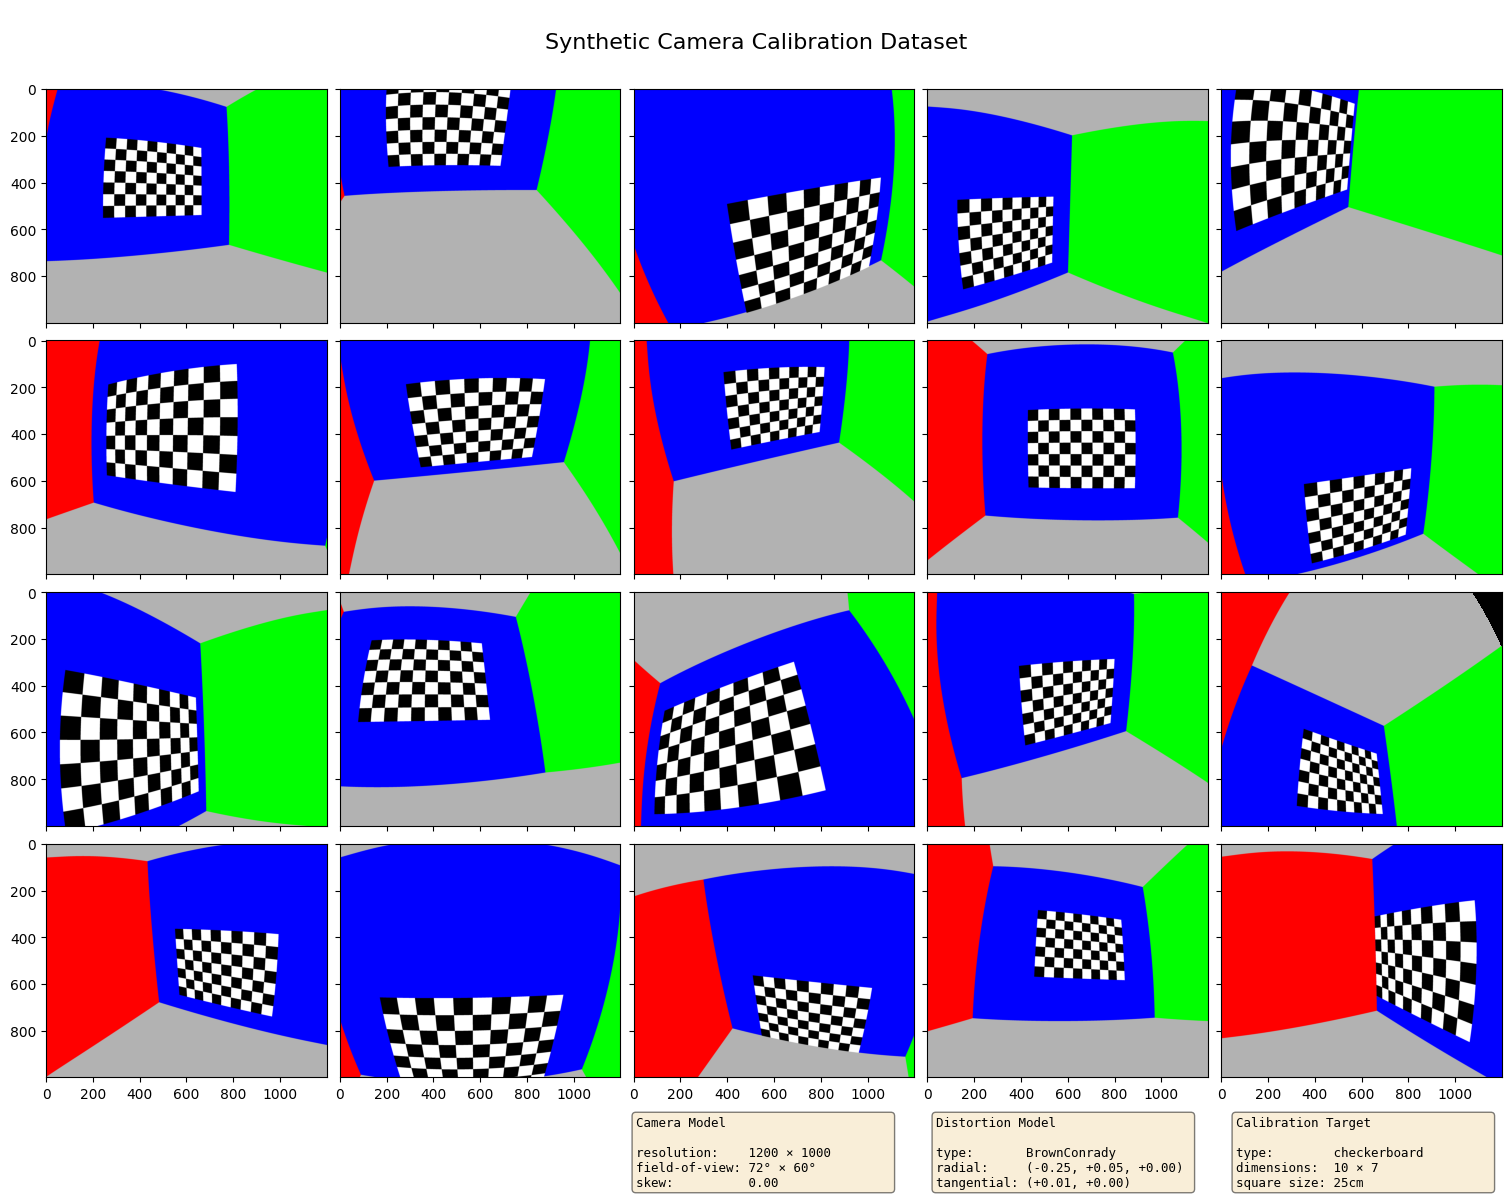

In [8]:
nrows = 4
ncols = 5

image_aspect_ratio = camera.res_xy[1] / camera.res_xy[0]
fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(ncols*3, nrows*3*image_aspect_ratio+1.0),
    sharex="all", sharey="all", layout="constrained"
)

fig.suptitle(f"\nSynthetic Camera Calibration Dataset\n", fontsize=16)

# plot images
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i])

# create info boxes

fov_x, fov_y = camera.get_fov(degrees=True)

info_text_cmod = f"""\
Camera Model

resolution:    {camera.res_xy[0]} × {camera.res_xy[1]}
field-of-view: {fov_x:.0f}° × {fov_y:.0f}°
skew:          0.00\
"""

info_text_dist = f"""\
Distortion Model

type:       BrownConrady
radial:     ({distortion.k1:+.2f}, {distortion.k2:+.2f}, {distortion.k3:+.2f})
tangential: ({distortion.p1:+.2f}, {distortion.p2:+.2f})\
"""

info_text_calib = f"""\
Calibration Target

type:        checkerboard
dimensions:  10 × 7
square size: 25cm\
"""

place_info_textbox(fig, 0.42, -0.01, info_text_cmod,  box_width_chars=34)
place_info_textbox(fig, 0.62, -0.01, info_text_dist,  box_width_chars=34)
place_info_textbox(fig, 0.82, -0.01, info_text_calib, box_width_chars=34)


fig.savefig("../media/synthetic_calibration_dataset_image_grid.png", bbox_inches="tight")

## Save Results

In [9]:
dataset_dir = "./datasets/example_synthetic_calibration_dataset"

import os
os.makedirs(dataset_dir, exist_ok=True)

In [10]:
# save images as PNGs
os.makedirs(f"{dataset_dir}/images", exist_ok=True)

image_filenames = []

for i, image in enumerate(images):
    img_fname = f"image_{i:03}.png"
    plt.imsave(f"{dataset_dir}/images/{img_fname}", image)

    image_filenames.append(img_fname)

In [11]:
# save ground-truth camera poses as a CSV file
import pandas

data = []
for img_fname, cam_pose in zip(image_filenames, camera_poses):
    q = cam_pose.R.as_quat()
    data.append([img_fname, *cam_pose.t, *q])

df = pandas.DataFrame(data, columns=["img_fname", "x", "y", "z", "qx", "qy", "qz", "qw"])

# Save to CSV
df.to_csv(f"{dataset_dir}/true_camera_poses.csv", index=False, float_format="%+.9f")

In [12]:
# save camera model as a JSON file
import json

# camera_model_data = camera.to_dict()
camera_model_data = {"TODO": "TODO"}

with open(f"{dataset_dir}/true_camera_model.json", mode="w+") as f:
    json.dump(camera_model_data, f, indent=4)
